# Example 1B - Training of virtual staining of brightfield images 

Example code to train a neural network to virtually stain brightfield images obtaining the corresponding images for nuclei, lipids and cytoplasm.

This code can be easily adapted to train other virtual staining neural networks by changing the neural network and training parameters in section 1.1 and 

version 1.0 <br />
15 November 2020 <br />
Benjamin Midtvedt, Jesús Pineda Castro, Saga Helgadottir, Daniel Midtvedt & Giovanni Volpe <br />
Soft Matter Lab @ GU <br />
http://www.softmatterlab.org

## 0. Imports
 
Import all necessary packages. These include standard Python packages as well as the core of DeepTrack 2.0 (`deeptrack`) and some specialized classes for this virtual staining (`apido`).

In [1]:
import os
import glob
import random
import itertools
from timeit import default_timer as timer

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# DeepTrack 2.0 code
import apido
from apido import deeptrack as dt

import os
#import psutil
#process = psutil.Process(os.getpid())


## 1. Define input and output

Set constants to determine the input and output images

### 1.1 Neural-network model parameters

Parameters of the neural network model. These are:

* `GENERATOR_BREADTH`: determines the number of features in the first level of the generator

* `GENERATOR_DEPTH`: Depth of the generator U-Net

* `DISCRIMINATOR_DEPTH`: Depth of the discriminator convolutional encoder

* `MAE_LOSS_WEIGHT`: the weighting of the MAE loss vs. the adversarial loss

* `EPOCHS`: number of epochs to train. We recommend the range 200-500 epochs.

In [2]:
GENERATOR_BREADTH = 16
GENERATOR_DEPTH = 6
DISCRIMINATOR_DEPTH = 5
MAE_LOSS_WEIGHT = 0.001
EPOCHS = 50

### 1.2 User-defined constants for loading data and saving model

Constants defined by the user:

* `DATASET_PATH`: Input path

* `OUTPUT_PATH`: Where to save the model

Note that the training set is not provided for the `apidocytes_60x` dataset

In [3]:
MAGNIFICATION = "60x"
DATASET_PATH = "./datasets/apidocytes_" + MAGNIFICATION
TRAINING_PATH = os.path.join(DATASET_PATH, "training_data") 
OUTPUT_PATH = "./models/"

VALIDATION_WELLS_AND_SITES = [
    ("B03", 2),
    ("C04", 4),
    ("B04", 3),
    ("C02", 1),
    ("D02", 3),
    ("B03", 1),
    ("D04", 12),
    ("B04", 1),
    ("B03", 10),
    ("B04", 4),
    ("C02", 4),
    ("D02", 9),
    ("C04", 9),
    ("D04", 1),
    ("C02", 6),
]

### 1.3 Inferred constants

Constants inferred from the user input

In [4]:
file_name_struct = "AssayPlate_Greiner_#655090_{0}_T0001F{1}L01A0{2}Z0{3}C0{2}.tif"

PATH_TO_OUTPUT = os.path.normpath(OUTPUT_PATH)

Infer full path to dataset

In [5]:
_glob_results = glob.glob(TRAINING_PATH)

if len(_glob_results) == 0:
    raise ValueError("No path found matching glob {0}".format(_glob_struct))
elif len(_glob_results) > 1:
    from warnings import warn
    warn("Multiple paths found! Using {0}".format(_glob_results[-1]))

PATH_TO_MAGNIFICATION = os.path.normpath(_glob_results[-1])

In [6]:
print("Loading images from: \t", PATH_TO_MAGNIFICATION)
print("Saving results to: \t", PATH_TO_OUTPUT)

Loading images from: 	 datasets\apidocytes_60x\training_data
Saving results to: 	 models


## 2. Load train data

We define a data pipeline for loading images from storage. This uses DeepTrack 2.0, and follows the structure of

1. Load each z-slice of a well-site combination and concatenate them.
2. Pad the volume such that the first two dimensions are multiples of 32 (required by the model).
3. Correct for misalignment of the fluorescence channel and the brightfield channel (by a pre-calculated parametrization of the offset as a function of magnification and the site).

### 2.1 Find all wells and sites

We create an iterator over each well and site. `itertools.product` produces an iterator over each combination of its input. In this case, each site in each well.

In [7]:
wells_and_sites = list(
    itertools.product(
        ["B03", "B04", "C02", "C03", "C04", "D02", "D03", "D04"],
        range(1, 13) 
    )
)

In [8]:
random.seed(1)
random.shuffle(wells_and_sites)

training_set = [w_s_tuple for w_s_tuple in wells_and_sites if w_s_tuple not in VALIDATION_WELLS_AND_SITES]
validation_set = VALIDATION_WELLS_AND_SITES

print("Training on {0} images".format(len(training_set)))
print("Validating on {0} images".format(len(validation_set)))

Training on 81 images
Validating on 15 images


### 2.2 The root feature

We use DeepTrack 2.0 to define the data loader pipeline. The pipeline is a sequence of `features`, which perform computations, controlled by `properties`, which are defined when creating the features. (Note that we any property with any name and value to a feature; if a property is not used by the feature, we refer to it as a dummy property.)

The feature `root` is a `DummyFeature`, which is just a container of dummy properties and does not perform any computations.
It takes the following arguments:

* `well_site_tuple` is a dummy property that cycles through the well-site combinations in `wells_and_sites`
* `well` is a dummy property that extracts the well from the `well_site_tuple`
* `site` is a dummy property that extracts the site from the `well_site_tuple`

Note that `well` and `site` are functions that take `well_site_tuple` as argument. These are dependent properties, and DeepTrack 2.0 will automatically ensure that they receive the correct input.

In [9]:
training_iterator = itertools.cycle(training_set)
validation_iterator = itertools.cycle(validation_set)

def get_next_well_and_site(validation):
    if validation:
        return next(validation_iterator)
    else:
        return next(training_iterator)

# Accepts a tuple of form (well, site), and returns the well
def get_well_from_tuple(well_site_tuple):
    return well_site_tuple[0]

# Accepts a tuple of form (well, site), and returns the site as 
# a string formated to be of length 3.
def get_site_from_tuple(well_site_tuple):
    site_string = "00" + str(well_site_tuple[1])
    return site_string[-3:]



root = dt.DummyFeature(
    well_site_tuple=get_next_well_and_site,           # On each update, root will grab the next value from this iterator
    well=get_well_from_tuple,                         # Grabs the well from the well_site_tuple
    site=get_site_from_tuple,                         # Grabs and formats the site from the well_site_tuple
)

### 2.3 The brightfield image loader

We use `deeptrack.LoadImage` to load and concatenate a brightfield stack. It takes the following arguments:

* `**root.properties` means that we take the properties of `root` (of importance `well` and `site`). The other properties of LoadImage will now depend on these.
* `file_names` is a dummy property, which takes the current well and site as input, and creates a list of file names that we want to load.
* `path` is a property used by `LoadImage` to determine which files to load. We calculate it by taking `file_names` as input and returning a list of paths using `os.path.join`.

Since `path` is a list, `LoadImage` stacks the images along the last dimension, creating a shaped volume with dimensions (width, height, 7).

In [10]:
brightfield_loader = dt.LoadImage(
    **root.properties,
    file_names=lambda well, site: [file_name_struct.format(well, site, 4, z) for z in range(1, 8)],
    path=lambda file_names: [os.path.join(PATH_TO_MAGNIFICATION, file_name) for file_name in file_names]
)

### 2.4 The fluorescence image loader

We use `deeptrack.LoadImage` to load and concatenate a fluorescence stack. It takes the following arguments:

* `**root.properties` means that we take the properties of `root` (of importance `well` and `site`). The other properties of LoadImage will now depend on these.
* `file_names` is a dummy property, which takes the current well and site as input, and creates a list of file names that we want to load.
* `path` is a property used by `LoadImage` to determine which files to load. We calculate it by taking `file_names` as input and returning a list of paths using `os.path.join`.

Since `path` is a list, `LoadImage` stacks the images along the last dimension, creating a shaped volume with dimensions (width, height, 3).

In [11]:
fluorescence_loader = dt.LoadImage(
    **root.properties,
    file_names=lambda well, site: [file_name_struct.format(well, site, action, 1) for action in range(1, 4)],
    path=lambda file_names: [os.path.join(PATH_TO_MAGNIFICATION, file_name) for file_name in file_names],
)

### 2.5 Offset adjustment

Offset adjustments using affine transformations. The offset is parametrized as a function of the site.

`Combine` creates a feature that reslves and returns `brightfield_loader` and `fluorescence_loader`. We use this to calculate parameters of the datasets, including normalization coefficients and offset correction. 

We bin the offset calculation as a function of the site.

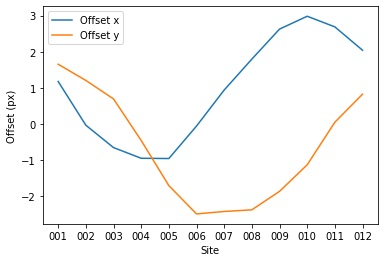

In [12]:
data_feature = dt.Combine([brightfield_loader, fluorescence_loader])

params = apido.get_dataset_parameters(DATASET_PATH, data_feature=data_feature, n_images=81)
binned_offsets = params.bin("offset", "site", reducer = np.mean)

sites, values = zip(*sorted(binned_offsets.items()))

plt.plot(sites, np.array(values)[:, 0])
plt.plot(sites, np.array(values)[:, 1])

plt.legend(["Offset x", "Offset y"])
plt.xlabel("Site")
plt.ylabel("Offset (px)")
plt.show()

The properties are set as follows:

* `translate` sets how much we translate the image in pixels. It is a tuple representing the (x, y) shift. We grab it from the binned offset dict.
* `root.properties` grabs the site from the root feature.

In [13]:
correct_offset = dt.Affine(
    translate=lambda site: binned_offsets[site],
    **root.properties
)

### 2.6 Define augmentations

We use three kinds of augmentations: Mirroring (`deeptrack.FlipLR`), Affine transformations (`deeptrack.ElasticTransformation`), and Distortions (`deeptrack.Crop`)

In [14]:
flip = dt.FlipLR()

affine = dt.Affine(
    rotate=lambda: np.random.rand() * 2 * np.pi,
)

corner = int(512 * (np.sqrt(2) - 1) / 2)
cropping  = dt.Crop(
    crop=(512, 512, None),
    corner=(corner, corner, 0)
)

### 2.7 Create the pipeline 

We use the (`+`) operator to chain the features, defining the execution order. In DeepTrack 2.0, this means that the output of the feature on the left, is passed as the input to the feature on the right. This is done in the following steps:

1. `corrected_brightfield` is generated by offsetting the `brightfield_loader`
2. `data_pair` is created with input images and targets
3. `augmented_data` are defined by using the augmentations as well as the cropping
4. `validation_data` is created
5. `dataset` is created

In [15]:
corrected_brightfield = brightfield_loader + correct_offset

data_pair = dt.Combine([corrected_brightfield, fluorescence_loader])

padded_crop_size = int(512 * np.sqrt(2))

cropped_data = dt.Crop(
    data_pair,
    crop=(padded_crop_size, padded_crop_size, None),
    updates_per_reload=16,
    corner=lambda: (*np.random.randint(5000, size=2), 0),
)

augmented_data = cropped_data + affine + cropping

validation_data = data_pair + dt.PadToMultiplesOf(multiple=(32, 32, None))

dataset = dt.ConditionalSetFeature(
    on_true=validation_data,
    on_false=augmented_data,
    condition="is_validation",
    is_validation=lambda validation: validation
) + dt.AsType("float64")

## 3. Define generator

We use generators to interface DeepTrack 2.0 features with Keras training routines. In DeepTrack 2.0, we have defined some special generators that speed up training. Here, we will use `deeptrack.ContinuousGenerator`, which continuosly geenrate augmented training images and makes them available for training the neural network model.

In [16]:
generator = dt.generators.ContinuousGenerator(
    dataset,
    batch_function=lambda image: image[0],
    label_function=lambda image: image[1],
    batch_size=2,
    min_data_size=50,
    max_data_size=100
)

## 4. Define model

Here, we use a GAN with a U-Net generator and a convolutional encoder discriminator. The generator is trained on MSE of the GAN error and MAE of the pixel difference. The discriminator is trained using MSE loss.

More details are provided in the report.

We also compile the assembled GAN with metrics, which include feature-wise MAE.

In [17]:
GAN_generator = apido.generator(GENERATOR_BREADTH, GENERATOR_DEPTH, params)
GAN_discriminator = apido.discriminator(DISCRIMINATOR_DEPTH, params)

 

GAN = dt.models.cgan(
    generator=GAN_generator,
    discriminator=GAN_discriminator,
    discriminator_loss="mse",
    discriminator_optimizer=Adam(lr=0.0002, beta_1=0.5),
    assemble_loss=["mse", "mae"],
    assemble_optimizer=Adam(lr=0.0002, beta_1=0.5),
    assemble_loss_weights=[
        1 - MAE_LOSS_WEIGHT,
        MAE_LOSS_WEIGHT
    ],
)

GAN.compile(loss="mae", metrics=apido.metrics("60x"))

## 5. Train model

We execute the dataset pipeline, setting the option `validation` to be True in the update step. This toggles the ConditionalSetFeature to skip the augmentation, as well as making `root` draw the site-tuple from the validation set.

Following this we initialize the generator using the `with` statements, which launches a thread to generate `min_data_size` samples before starting training. Finally `fit` starts the training.

In [18]:
validation_inputs = []
validation_targets = []

for _ in range(len(validation_set)):
    data_tuple = dataset.update(validation=True).resolve()
    validation_inputs.append(data_tuple[0])
    validation_targets.append(data_tuple[1])
    
validation_inputs = np.array(validation_inputs)
validation_targets = np.array(validation_targets)

In [19]:
with generator:
    
    h = GAN.fit(
        generator, 
        epochs=EPOCHS,
        validation_data=(
            np.array(validation_inputs),
            np.array(validation_targets)
        ),
        validation_batch_size=1
    )

Generating 51 / 50 samples before starting training
Epoch 1/50
25/25 [==============================] - ETA: 0s - d_loss: 1.0839 - g_loss: 1.0679 - nuclei: 1.6660 - lipids: 1.0072 - cyto: 2.1669

KeyboardInterrupt: 

## 7. Visualize validation set

We plot and show model predictions for each image in the validation set.

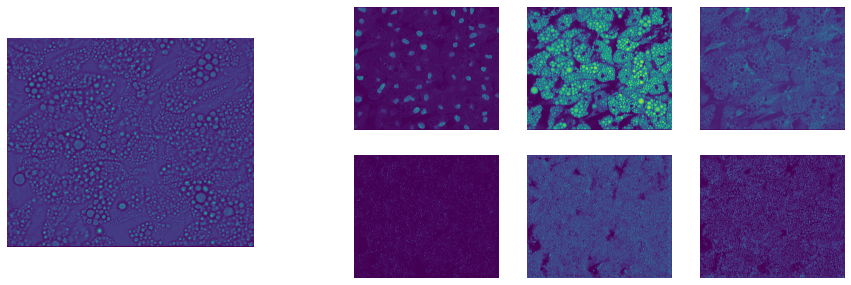

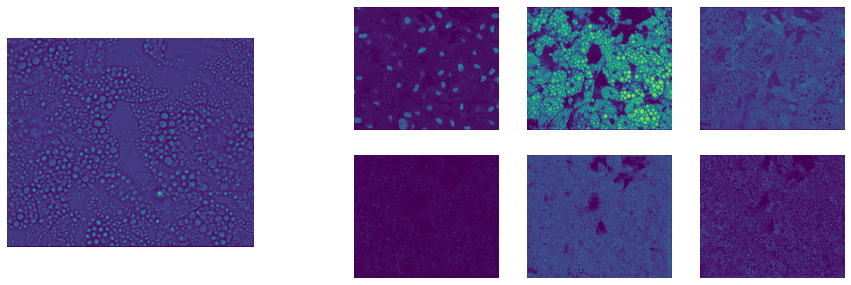

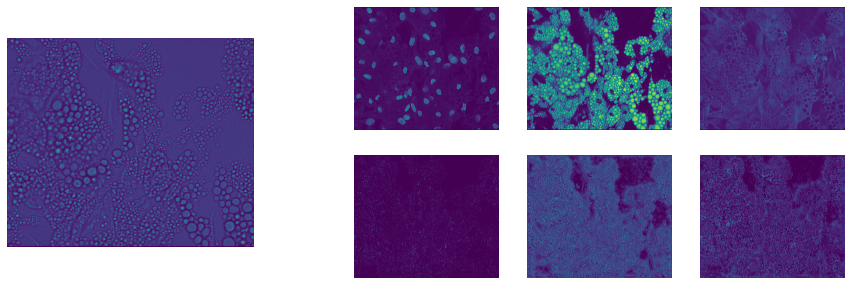

KeyboardInterrupt: 

In [20]:
prediction = GAN.generator.predict(np.array(validation_inputs), batch_size=4)

for brightfield, targets, prediction in zip(validation_inputs, validation_targets, prediction):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(brightfield[:, :, 0])
    plt.axis("off")
    
    plt.subplot(2,5,3)
    plt.imshow(targets[:, :, 0])
    plt.axis("off")
    plt.subplot(2,5,4)
    plt.imshow(targets[:, :, 1])
    plt.axis("off")
    plt.subplot(2,5,5)
    plt.imshow(targets[:, :, 2])
    plt.axis("off")
    
    plt.subplot(2,5,8)
    plt.imshow(prediction[:, :, 0])
    plt.axis("off")
    plt.subplot(2,5,9)
    plt.imshow(prediction[:, :, 1])
    plt.axis("off")
    plt.subplot(2,5,10)
    plt.imshow(prediction[:, :, 2])
    plt.axis("off")
    plt.show()

## 7. Save model

We save the generator and the discriminator seperately. The folder is named after the current date and the user which is running the notebook..

In [ ]:
folder_name = apido.get_checkpoint_name("virtual_stainer")

# Save generator
generator_checkpoint_path = os.path.join(PATH_TO_OUTPUT, folder_name, "generator_checkpoint")
os.makedirs(generator_checkpoint_path, exist_ok=True)
GAN.generator.save(generator_checkpoint_path)

# Save discriminator
discriminator_checkpoint_path = os.path.join(PATH_TO_OUTPUT, folder_name, "discriminator_checkpoint")
os.makedirs(discriminator_checkpoint_path, exist_ok=True)
GAN.discriminator.save(discriminator_checkpoint_path)